----

In [1]:
#    GNU LESSER GENERAL PUBLIC LICENSE
#    Version 3, 29 June 2007
#    Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
#    Everyone is permitted to copy and distribute verbatim copies
#    of this license document, but changing it is not allowed.

#    James Gaboardi, 2016

-----

## Spatial Optimization Model Building in Python: Cplex v. Gurobi
## *p*-Median Problem Holding Cost Matrix Constant

----

#### James D. Gaboardi &nbsp;&nbsp; |  &nbsp;&nbsp; Florida State University &nbsp; &nbsp;|  &nbsp;&nbsp; Department of Geography 

----


In [2]:
# Local path on user's machine
path = '/Users/jgaboardi/Desktop/CPLEX_v_Gurobi/Data/'

# Imports
import pysal as ps
import geopandas as gpd
import numpy as np
import networkx as nx
import shapefile as shp
from shapely.geometry import Point
import shapely
from collections import OrderedDict
import pandas as pd
import qgrid
import cplex as cp
import gurobipy as gbp
import time
import bokeh
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file, show
from bokeh.models import (HoverTool, BoxAnnotation, GeoJSONDataSource, 
                          GMapPlot, GMapOptions, ColumnDataSource, Circle, 
                          DataRange1d, PanTool, WheelZoomTool, BoxSelectTool,
                          ResetTool, MultiLine)
import utm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
output_notebook()

/Users/jgaboardi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading BokehJS ...

In [3]:
# Waverly  Hills
STREETS = gpd.read_file(path+'Waverly_Trim_2/Waverly_Trim_2.shp')
# Leon County
#STREETS = gpd.read_file(path+'LCSTSEG/LCSTSEG.shp')
STREETS.to_crs(epsg=2779, inplace=True) # NAD83(HARN) / Florida North
STREETS.to_file(path+'WAVERLY/WAVERLY.shp')
STREETS[:5]

,ACCESS_,ALIAS_NAME,BUILT_DATE,BUILT_STAT,CLASS,CONN_TYPE,COUNTY,EDIT_BY,EDIT_DATE,EDIT_TYPE,...,SOURCE,SPEED,STATUS,SUFFIX,TF_COST,THEOR_RANG,TRAVEL_FLA,TYPE,T_ELEV,geometry
0,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.090264,N,2,RD,0,LINESTRING (623093.510832076 164171.1041567803...
1,None,SR - 61,None,BUILT,8,INTE,LEON,HAGESETHC,2014-02-26,O,...,FDOR2007TFC,25,O,None,0.017222,N,2,RD,0,LINESTRING (622515.1922320754 163214.635256776...
2,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.091403,N,2,RD,0,LINESTRING (623548.0931320738 165478.253356780...
3,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.090467,N,2,RD,0,LINESTRING (623167.8413320724 164328.903156780...
4,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.089032,N,2,RD,0,LINESTRING (623546.4237320729 165409.808056779...


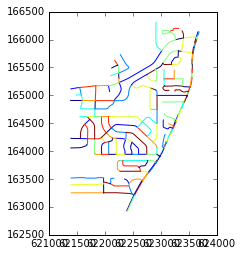

In [4]:
STREETS.plot()

In [5]:
ntw = ps.Network(path+'WAVERLY/WAVERLY.shp')  # Instantiate Network
shp_W = ps.open(path+'WAVERLY/WAVERLY.shp')   # Instantiate the WAVERLY .shp for late use

In [6]:
buff = STREETS.buffer(200)  #Buffer
buff[:5]

0    POLYGON ((623182.150053937 164350.7973140236, ...
1    POLYGON ((622609.2522032181 163391.5139959676,...
2    POLYGON ((623558.0958294807 165678.3788460373,...
3    POLYGON ((623266.5120703815 164503.29148902, 6...
4    POLYGON ((623558.3641320487 165609.8080567809,...
dtype: object

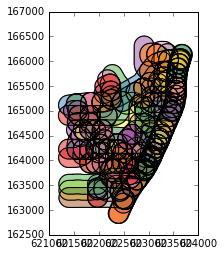

In [7]:
buff.plot()

In [8]:
buffU = buff.unary_union  #Buffer Union
buff1 = gpd.GeoSeries(buffU)
buff1.crs = STREETS.crs
Buff = gpd.GeoDataFrame(buff1, crs=STREETS.crs)
Buff.columns = ['geometry']
Buff

,geometry
0,"POLYGON ((622673.874236838 163055.508300971, 6..."


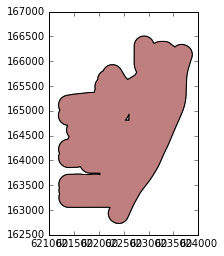

In [9]:
Buff.plot()

In [10]:
np.random.seed(352)
x = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 1000)
np.random.seed(850)
y = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 1000)  
coords0= zip(x,y)
coords = [shapely.geometry.Point(i) for i in coords0]
Rand = gpd.GeoDataFrame(coords)
Rand.crs = STREETS.crs
Rand.columns = ['geometry']
Rand[:5]

,geometry
0,POINT (623388.4926405598 166286.4795721661)
1,POINT (622672.4092589854 162943.9994787998)
2,POINT (621913.3153830337 164903.3379650218)
3,POINT (621612.0857702466 164217.1288344094)
4,POINT (623414.8982675247 163698.4405537729)


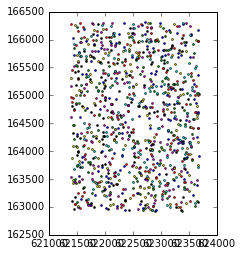

In [11]:
Rand.plot()

In [12]:
Inter = [Buff['geometry'].intersection(p) for p in Rand['geometry']]
INTER = gpd.GeoDataFrame(Inter, crs=STREETS.crs)
INTER.columns = ['geometry']
INTER[:5]

,geometry
0,POINT (623388.4926405598 166286.4795721661)
1,()
2,POINT (621913.3153830337 164903.3379650218)
3,POINT (621612.0857702466 164217.1288344094)
4,()


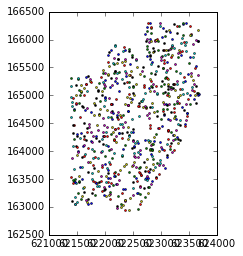

In [13]:
INTER.plot()

In [14]:
# Add records that are points within the buffer
point_in = []
for p in INTER['geometry']:
    if type(p) == shapely.geometry.point.Point:
        point_in.append(p)
point_in[:5]

In [15]:
# Client and Service
CLIENT = gpd.GeoDataFrame(point_in[:100], crs=STREETS.crs)
CLIENT.columns = ['geometry']
SERVICE = gpd.GeoDataFrame(point_in[-50:], crs=STREETS.crs)
SERVICE.columns = ['geometry']
CLIENT.to_file(path+'CLIENT')
SERVICE.to_file(path+'SERVICE')

In [16]:
CLIENT[:5]

,geometry
0,POINT (623388.4926405598 166286.4795721661)
1,POINT (621913.3153830337 164903.3379650218)
2,POINT (621612.0857702466 164217.1288344094)
3,POINT (621854.4787915241 163374.7302612905)
4,POINT (621655.1410893091 163122.8990482465)


In [17]:
SERVICE[:5]

,geometry
0,POINT (622173.6292703348 164402.6147558152)
1,POINT (621466.0242040555 163170.3188358559)
2,POINT (622029.8184639579 164423.6281353595)
3,POINT (623570.2426585117 165267.5085102673)
4,POINT (622171.9423363927 165439.4139756552)


In [18]:
g = nx.Graph() # Roads & Nodes
g1 = nx.MultiGraph() # Edges and Vertices
GRAPH_client = nx.Graph() # Clients 
g_client = nx.Graph() # Snapped Clients
GRAPH_service = nx.Graph() # Service
g_service = nx.Graph() # Snapped Service

In [19]:
points_client = {} 
points_service = {}

CLI = ps.open(path+'CLIENT/CLIENT.shp')
for idx, coords in enumerate(CLI):
    GRAPH_client.add_node(idx)
    points_client[idx] = coords
    GRAPH_client.node[idx] = coords
    
SER = ps.open(path+'SERVICE/SERVICE.shp')
for idx, coords in enumerate(SER):
    GRAPH_service.add_node(idx)
    points_service[idx] = coords
    GRAPH_service.node[idx] = coords

In [20]:
# Client Weights for demand
np.random.seed(850)
Ai = np.random.randint(1, 5, len(CLI))
Ai = Ai.reshape(len(Ai),1)
AiSum = np.sum(Ai) # Sum of Weights (Total Demand)

In [21]:
client = shp.Writer(shp.POINT) # Client Shapefile
# Add Random Points
for i,j in CLI:
    client.point(i,j)
# Add Fields
client.field('client_ID')
client.field('Weight')
counter = 0
for i in range(len(CLI)):
    counter = counter + 1
    client.record('client_' + str(counter), Ai[i])
client.save(path+'Simulated/RandomPoints_CLIENT') # Save Shapefile 

In [22]:
service = shp.Writer(shp.POINT) #Service Shapefile
# Add Random Points
for i,j in SER:
    service.point(i,j)
# Add Fields
service.field('y_ID')
service.field('x_ID')
counter = 0
for i in range(len(SER)):
    counter = counter + 1
    service.record('y' + str(counter), 'x' + str(counter))
service.save(path+'Simulated/RandomPoints_SERVICE') # Save Shapefile 

In [23]:
# Snap
Snap_C = ntw.snapobservations(path+'Simulated/RandomPoints_CLIENT.shp', 
                     'Rand_Points_CLIENT', attribute=True)
Snap_S = ntw.snapobservations(path+'Simulated/RandomPoints_SERVICE.shp', 
                     'Rand_Points_SERVICE', attribute=True)

In [24]:
# Create Lat & Lon lists of the snapped service locations
y_snapped = []
x_snapped = []
for i,j in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    y_snapped.append(j[0]) 
    x_snapped.append(j[1])

In [25]:
service_SNAP = shp.Writer(shp.POINT) # Snapped Service Shapefile
# Add Points
for i,j in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    service_SNAP.point(j[0],j[1])
# Add Fields
service_SNAP.field('y_ID')
service_SNAP.field('x_ID')
service_SNAP.field('LAT')
service_SNAP.field('LON')
counter = 0
for i in range(len(ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates)):
    counter = counter + 1
    service_SNAP.record('y' + str(counter), 'x' + str(counter), y_snapped[i], x_snapped[i])
service_SNAP.save(path+'Snapped/SERVICE_Snapped') # Save Shapefile 

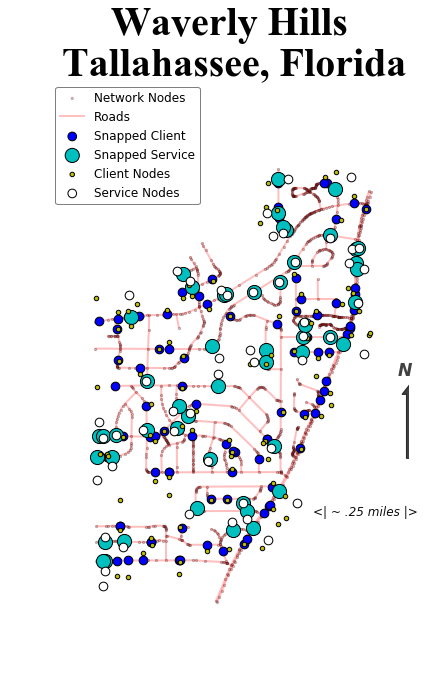

In [26]:
mpl.rcParams['figure.figsize']=5,8
# Draw Graph of Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

# Draw Graph of Snapped Client Nodes
g_client = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_CLIENT'].snapped_coordinates.iteritems():
    g_client.add_node(p)
    g_client.node[p] = coords
nx.draw(g_client, ntw.pointpatterns['Rand_Points_CLIENT'].snapped_coordinates, 
        node_size=75, alpha=1, node_color='b')

# Draw Graph of Snapped Service Nodes
g_service = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    g_service.add_node(p)
    g_service.node[p] = coords
nx.draw(g_service, ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates, 
        node_size=200, alpha=1, node_color='c')

# Draw Graph of Random Client Points
nx.draw(GRAPH_client, points_client, 
    node_size=20, alpha=1, node_color='y')

# Draw Graph of Random Service Points
nx.draw(GRAPH_service, points_service, 
    node_size=75, alpha=1, node_color='w')

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Snapped Client']=g_client
LEGEND['Snapped Service']=g_service
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Service Nodes']=GRAPH_service
plt.legend(LEGEND, loc='upper left', fancybox=True, framealpha=0.5, scatterpoints=1)

# Title
plt.title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# Must be changed for different spatial resolutions, etc.
plt.arrow(624000, 164050, 0.0, 500, width=50, head_width=125, 
          head_length=75, fc='k', ec='k',alpha=0.75,)
plt.annotate('N', xy=(623900, 164700), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)
plt.annotate('<| ~ .25 miles |>', xy=(623200, 163600), 
             fontstyle='italic', fontsize='large', alpha=0.95)

plt.show()

In [27]:
t1 = time.time()
All_Neigh_Dist = ntw.allneighbordistances(
                        sourcepattern=ntw.pointpatterns['Rand_Points_CLIENT'],
                        destpattern=ntw.pointpatterns['Rand_Points_SERVICE'])
All_Dist_MILES = All_Neigh_Dist * 0.000621371 # to miles
print All_Dist_MILES.shape
All_Dist_MILES[0]
print time.time() - t1

(100, 50)
9.47994709015


In [28]:
# PANDAS DATAFRAME OF p/y results
p_list = []
for i in range(1, len(SER)+1):
    p = 'p='+str(i)
    p_list.append(p)
y_list = []
for i in range(1, len(SER)+1):
    y = 'y'+str(i)
    y_list.append(y)

In [29]:
pydf_M_cplex = pd.DataFrame(index=p_list,columns=y_list)
pydf_M_gurobi = pd.DataFrame(index=p_list,columns=y_list)
solve_df = pd.DataFrame(index=p_list)

In [30]:
# PMP
VAL_PMP_cplex = []
AVG_PMP_cplex = []
VAL_PMP_gurobi = []
AVG_PMP_gurobi = []
solve_time_cplex = []
solve_time_gurobi = []

In [31]:
for p in range(1, len(SER)+1): #--------- for all [p] in p = length(service facilities)
    
    # CPLEX
    
    t1_PMP_cplex = time.time()

    np.random.seed(352)

    m = cp.Cplex()                                      # Create model
    m.parameters.emphasis.mip.set(2)                    # Set MIP emphasis to '2' --> Optimal
    m.set_problem_type(m.problem_type.LP)               # Set problem type
    m.objective.set_sense(m.objective.sense.minimize)   # Objective Function Sense  ==>  Minimize


    #     1. Read In Data
    # Cost Matrix
    Cij = All_Dist_MILES
    Ai = Ai
    AiSum = AiSum
    Sij = Ai * Cij
    client_nodes = range(len(Sij))
    service_nodes = range(len(Sij[0]))
    all_nodes_len = len(Sij) * len(Sij[0])
    ALL_nodes_range = range(all_nodes_len)

    client_var = []
    for orig in client_nodes:
            client_var.append([])
            for dest in service_nodes:
                client_var[orig].append('x'+str(orig+1)+'_'+str(dest+1))

    fac_var = []
    for dest in service_nodes:
            fac_var.append([])
            fac_var[dest].append('y' + str(dest+1))


    #  Add Variables
    # Add Client Decision Variables
    m.variables.add(names = [client_var[i][j] for i in client_nodes for j in service_nodes],
                            obj = [Sij[i][j] for i in client_nodes for j in service_nodes], 
                            lb = [0] * all_nodes_len, 
                            ub = [1] * all_nodes_len, 
                            types = ['B'] * all_nodes_len)
    # Add Service Decision Variable
    m.variables.add(names = [fac_var[j][0] for j in service_nodes],
                            lb = [0] * len(Sij[0]), 
                            ub = [1] * len(Sij[0]), 
                            types = ['B'] * len(Sij[0]))

    #    3. Add Constraints
    # Add Assignment Constraints
    for orig in client_nodes:       
        assignment_constraints = cp.SparsePair(ind = [client_var[orig][dest] 
                                                for dest in service_nodes],                           
                                                val = [1] * len(Sij[0]))
        m.linear_constraints.add(lin_expr = [assignment_constraints],                 
                                    senses = ['E'], 
                                    rhs = [1]);
    # Add Facility Constraint
    facility_constraint = cp.SparsePair(ind = [fac_var[j][0] for j in service_nodes], 
                                        val = [1.0] * len(Sij[0]))
    m.linear_constraints.add(lin_expr = [facility_constraint],
                                    senses = ['E'],
                                    rhs = [p])
    '''
    # Add Opening Constraint
    OC = [[client_var[i][j]] + [fac_var[j][0]] for i in client_nodes for j in service_nodes]
    for i in OC:
        opening_constraints = cp.SparsePair(ind = i, val = [-1.0, 1.0])
        m.linear_constraints.add(lin_expr = [opening_constraints], 
                                    senses = ['G'], 
                                    rhs = [0])
    '''
    # Add Opening Constraint
    OC = [[client_var[i][j]] + [fac_var[j][0]] for i in client_nodes for j in service_nodes]
    for i in OC:
        opening_constraints = [i, [-1.0, 1.0]]
        m.linear_constraints.add(lin_expr = [opening_constraints], 
                                    senses = ['G'], 
                                    rhs = [0])

    #    4. Optimize and Print Results
    m.solve()
    t2_PMP_cplex = time.time()-t1_PMP_cplex
    solve_time_cplex.append(t2_PMP_cplex)
    
    m.write(path+'LP_files/CPLEX_Pmedian'+str(p)+'.lp')
    solution = m.solution
    dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
    selected_M_cplex = OrderedDict()
    NEW_Records_PMP_cplex = []
    for f in fac_var:
        if 'x' in f[0]:
            pass
        elif solution.get_values(f[0]) > 0 :
            var = '%s' % f[0]
            selected_M_cplex[var]=(u"\u2588")
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PMP_cplex.append(x)
                else:
                    pass
    
    # Display solution.
    print '*******************************************************************'
    for f in fac_var:
        if solution.get_values(f[0]) > 0 :
            print 'Facility %s is open' % f[0]
    
    pydf_M_cplex = pydf_M_cplex.append(selected_M_cplex, ignore_index=True)
        
    # Instantiate Shapefile
    SHP_Median_cplex = shp.Writer(shp.POINT)
    # Add Points
    for idy,idx,x,y in NEW_Records_PMP_cplex:
        SHP_Median_cplex.point(float(x), float(y))
    # Add Fields
    SHP_Median_cplex.field('y_ID')
    SHP_Median_cplex.field('x_ID')
    SHP_Median_cplex.field('LAT')
    SHP_Median_cplex.field('LON')
    # Add Records
    for idy,idx,x,y in NEW_Records_PMP_cplex:
        SHP_Median_cplex.record(idy,idx,x,y)
    # Save Shapefile
    SHP_Median_cplex.save(path+'Results/CPLEX_Selected_Locations_Pmedian'+str(p)+'.shp')   

    val_m_cplex = solution.get_objective_value()
    VAL_PMP_cplex.append(round(val_m_cplex, 3))
    avg_m_cplex = float(val_m_cplex)/float(AiSum)
    AVG_PMP_cplex.append(round(avg_m_cplex, 3))
    
    print '*******************************************************************'
    print 'Solution status    = ' , solution.get_status(), ':', solution.status[solution.get_status()]
    print 'Facilities [p]     = ' , len(selected_M_cplex)
    print 'Total cost         = ' , val_m_cplex
    print 'Determination Time = ' , m.get_dettime(), 'ticks'
    print 'Real Time          = ' , t2_PMP_cplex, 'sec.'        
    print 'Matrix Shape       = ' , Sij.shape
    print '*******************************************************************'
    print '\n -- The p-Median Problem -- CPLEX'
    print ' [p] = ', str(p), '\n\n'
    
    
###############################################################################    
    
    #  Gurobi
    
    t1_PMP_gurobi = time.time()
    
    # Instantiate Model
    mPMP = gbp.Model(' -- p-Median -- ')
    # Turn off Gurobi's output
    mPMP.setParam('OutputFlag',False)

    # Add Client Decision Variables (iXj)
    client_var_PMP = []
    for orig in client_nodes:
        client_var_PMP.append([])
        for dest in service_nodes:
            client_var_PMP[orig].append(mPMP.addVar(vtype=gbp.GRB.BINARY,
                                            lb=0,
                                            ub=1,
                                            obj=Sij[orig][dest], 
                                            name='x'+str(orig+1)+'_'+str(dest+1)))

    # Add Service Decision Variables (j)
    serv_var_PMP = []
    for dest in service_nodes:
        serv_var_PMP.append([])
        serv_var_PMP[dest].append(mPMP.addVar(vtype=gbp.GRB.BINARY,
                                      lb=0,
                                      ub=1,
                                      name='y'+str(dest+1)))

    # Update the model
    mPMP.update()

    #     3. Set Objective Function
    mPMP.setObjective(gbp.quicksum(Sij[orig][dest]*client_var_PMP[orig][dest] 
                        for orig in client_nodes for dest in service_nodes), 
                        gbp.GRB.MINIMIZE)


    #     4. Add Constraints
    # Assignment Constraints
    for orig in client_nodes:
        mPMP.addConstr(gbp.quicksum(client_var_PMP[orig][dest] 
                        for dest in service_nodes) == 1)
    # Opening Constraints
    for orig in service_nodes:
        for dest in client_nodes:
            mPMP.addConstr((serv_var_PMP[orig][0] - client_var_PMP[dest][orig] >= 0))

    # Facility Constraint
    mPMP.addConstr(gbp.quicksum(serv_var_PMP[dest][0] for dest in service_nodes) == p)

    #     5. Optimize and Print Results
    # Solve
    mPMP.optimize()

    # Write LP
    mPMP.write(path+'LP_files/Gurobi_Pmedian'+str(p)+'.lp')
    t2_PMP_gurobi = time.time()-t1_PMP_gurobi
    solve_time_gurobi.append(t2_PMP_gurobi)
    # Record and Display Results
    print '\n*************************************************************************'
    selected_M_gurobi = OrderedDict()
    dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
    NEW_Records_PMP_gurobi = []
    for v in mPMP.getVars():
        if 'x' in v.VarName:
            pass
        elif v.x > 0:
            var = '%s' % v.VarName
            selected_M_gurobi[var]=(u"\u2588")
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PMP_gurobi.append(x)
                else:
                    pass
            print '    |                                            ', var

    pydf_M_gurobi = pydf_M_gurobi.append(selected_M_gurobi, ignore_index=True)

    # Instantiate Shapefile
    SHP_Median_gurobi = shp.Writer(shp.POINT)
    # Add Points
    for idy,idx,x,y in NEW_Records_PMP_gurobi:
        SHP_Median_gurobi.point(float(x), float(y))
    # Add Fields
    SHP_Median_gurobi.field('y_ID')
    SHP_Median_gurobi.field('x_ID')
    SHP_Median_gurobi.field('LAT')
    SHP_Median_gurobi.field('LON')
    # Add Records
    for idy,idx,x,y in NEW_Records_PMP_gurobi:
        SHP_Median_gurobi.record(idy,idx,x,y)
    # Save Shapefile
    SHP_Median_gurobi.save(path+'Results/GUROBI_Selected_Locations_Pmedian'+str(p)+'.shp')   

    print '    | Selected Facility Locations --------------  ^^^^ '
    print '    | Candidate Facilities [p] ----------------- ', len(selected_M_gurobi)
    val_m_gurobi = mPMP.objVal
    VAL_PMP_gurobi.append(round(val_m_gurobi, 3))
    print '    | Objective Value (miles) ------------------ ', val_m_gurobi
    avg_m_gurobi = float(val_m_gurobi)/float(AiSum)
    AVG_PMP_gurobi.append(round(avg_m_gurobi, 3))
    print '    | Avg. Value / Client (miles) -------------- ', avg_m_gurobi
    print '    | Real Time to Optimize (sec.) ------------- ', t2_PMP_gurobi
    print '*************************************************************************'
    print '\n -- The p-Median Problem -- Gurobi'
    print ' [p] = ', str(p), '\n\n'

Found incumbent of value 245.376857 after 0.00 sec. (0.59 ticks)
Tried aggregator 1 time.
Reduced MIP has 5101 rows, 5050 columns, and 15050 nonzeros.
Reduced MIP has 5050 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (20.84 ticks)
Probing changed sense of 5000 constraints.
Probing time = 2.75 sec. (1019.99 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 5101 rows and 5050 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (3.11 ticks)

Root node processing (before b&c):
  Real time             =    2.79 sec. (1048.73 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    2.79 sec. (1048.73 ticks)


Default row names c1, c2 ... being created.


*******************************************************************
Facility y14 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  1
Total cost         =  235.206809699
Determination Time =  1587.7100935 ticks
Real Time          =  3.41047000885 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  1 



*************************************************************************
    |                                             y14
    | Selected Facility Locations --------------  ^^^^ 
    | Candidate Facilities [p] -----------------  1
    | Objective Value (miles) ------------------  235.206809699
    | Avg. Value / Client (miles) --------------  0.94841455524
    | Real Time to Optimize (sec.) -------------  0.644337892532
*************************************************************************

 -- The 

Default row names c1, c2 ... being created.


*******************************************************************
Facility y6 is open
Facility y11 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  2
Total cost         =  159.574209698
Determination Time =  654.738305092 ticks
Real Time          =  0.86843585968 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  2 



*************************************************************************
    |                                             y6
    |                                             y11
    | Selected Facility Locations --------------  ^^^^ 
    | Candidate Facilities [p] -----------------  2
    | Objective Value (miles) ------------------  159.574209698
    | Avg. Value / Client (miles) --------------  0.643444393942
    | Real Time to Optimize (sec.) -------------  0.61386680603
*********

Default row names c1, c2 ... being created.


*******************************************************************
Facility y6 is open
Facility y11 is open
Facility y26 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  3
Total cost         =  117.100246335
Determination Time =  644.191979408 ticks
Real Time          =  1.06802797318 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  3 



*************************************************************************
    |                                             y6
    |                                             y11
    |                                             y26
    | Selected Facility Locations --------------  ^^^^ 
    | Candidate Facilities [p] -----------------  3
    | Objective Value (miles) ------------------  117.100246335
    | Avg. Value / Client (miles) --------------  0.47217841264

Default row names c1, c2 ... being created.


*******************************************************************
Facility y25 is open
Facility y26 is open
Facility y29 is open
Facility y31 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  4
Total cost         =  95.354871265
Determination Time =  637.597300529 ticks
Real Time          =  0.72158408165 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  4 



*************************************************************************
    |                                             y25
    |                                             y26
    |                                             y29
    |                                             y31
    | Selected Facility Locations --------------  ^^^^ 
    | Candidate Facilities [p] -----------------  4
    | Objective Value (miles) ------------------  9

Default row names c1, c2 ... being created.


*******************************************************************
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y31 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  5
Total cost         =  84.6417968695
Determination Time =  634.297227859 ticks
Real Time          =  0.995933055878 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  5 



*************************************************************************
    |                                             y26
    |                                             y27
    |                                             y28
    |                                             y29
    |                                             y31
    | Selected Facility Locations --------------  ^^^^ 
    | Candidate Facilities

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y6 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  6
Total cost         =  76.4057062342
Determination Time =  630.91481781 ticks
Real Time          =  0.804254055023 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  6 



*************************************************************************
    |                                             y2
    |                                             y6
    |                                             y26
    |                                             y27
    |                                             y28
    |                                             y29
    | Select

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  7
Total cost         =  69.2901211331
Determination Time =  630.905617714 ticks
Real Time          =  0.968667984009 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  7 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                                             y26
    |                                             y27
    |                                         

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y45 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  8
Total cost         =  63.226057853
Determination Time =  630.208288193 ticks
Real Time          =  0.988445997238 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  8 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                                             y26
    |                                             y27
    |                     

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y40 is open
Facility y45 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  9
Total cost         =  58.6977101536
Determination Time =  626.62826252 ticks
Real Time          =  1.1168820858 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  9 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                                             y26
    |                                             y27
    |  

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y10 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  10
Total cost         =  55.4418624535
Determination Time =  627.677709579 ticks
Real Time          =  0.942103862762 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  10 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                                             y10
    |                              

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  11
Total cost         =  52.7960453877
Determination Time =  626.009829521 ticks
Real Time          =  1.16819405556 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  11 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                                             y7
    |            

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  12
Total cost         =  50.7062103179
Determination Time =  657.811864853 ticks
Real Time          =  1.03665709496 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  12 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                                            

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  13
Total cost         =  48.6504932732
Determination Time =  625.952884674 ticks
Real Time          =  1.07927322388 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  13 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    |                       

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  14
Total cost         =  46.7111583213
Determination Time =  625.422704697 ticks
Real Time          =  0.742416143417 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  14 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                             y6
    | 

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y26 is open
Facility y27 is open
Facility y32 is open
Facility y36 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  15
Total cost         =  44.8074142683
Determination Time =  624.519694328 ticks
Real Time          =  0.982310056686 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  15 



*************************************************************************
    |                                             y2
    |                                             y5
    |                                 

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y26 is open
Facility y27 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  16
Total cost         =  43.1063831787
Determination Time =  625.553598404 ticks
Real Time          =  1.03540420532 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  16 



*************************************************************************
    |                                             y2
    |                                             y5
    |             

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y26 is open
Facility y27 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  17
Total cost         =  41.4165994835
Determination Time =  624.249102592 ticks
Real Time          =  0.745133161545 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  17 



*************************************************************************
    |                                             y2
    |                                            

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  18
Total cost         =  39.9756510442
Determination Time =  623.065961838 ticks
Real Time          =  0.73113489151 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  18 



*************************************************************************
    |                                             y2
    |                        

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  19
Total cost         =  38.5462541717
Determination Time =  624.258149147 ticks
Real Time          =  0.733947992325 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  19 



*************************************************************************
    |                                             y2
    |   

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y14 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  20
Total cost         =  37.2125730091
Determination Time =  623.037148476 ticks
Real Time          =  0.726906061172 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  20 



*************************************************************************
    |                                   

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  21
Total cost         =  36.1942318931
Determination Time =  623.119874001 ticks
Real Time          =  1.01695895195 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  21 



*************************************************************************
    |               

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  22
Total cost         =  35.2815734663
Determination Time =  622.344042778 ticks
Real Time          =  0.783222913742 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  22 



************************************************************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  23
Total cost         =  34.5222415376
Determination Time =  621.512688637 ticks
Real Time          =  0.737073898315 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  23 



***************************************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  24
Total cost         =  34.1046538366
Determination Time =  620.967860222 ticks
Real Time          =  0.734311103821 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  24 



******************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  25
Total cost         =  33.8661549508
Determination Time =  619.96117878 ticks
Real Time          =  0.762713909149 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p] =  25 



***********

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  26
Total cost         =  33.7412993293
Determination Time =  619.983059883 ticks
Real Time          =  0.749845981598 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median Problem -- CPLEX
 [p]

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  27
Total cost         =  33.6251965046
Determination Time =  619.718205452 ticks
Real Time          =  0.737459182739 sec.
Matrix Shape       =  (100, 50)
*******************************************************************

 -- The p-Median 

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  28
Total cost         =  33.5202383641
Determination Time =  619.662493706 ticks
Real Time          =  1.10720491409 sec.
Matrix Shape       =  (100, 50)
******************************************************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  29
Total cost         =  33.44147095
Determination Time =  619.526584625 ticks
Real Time          =  0.735895872116 sec.
Matrix Shape       =  (100, 50)
**********************************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  30
Total cost         =  33.3796452447
Determination Time =  620.128063202 ticks
Real Time          =  0.934092998505 sec.
Matrix Shape       =  (100, 50)
***********************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  31
Total cost         =  33.3203884755
Determination Time =  619.537721634 ticks
Real Time          =  0.994156122208 sec.
Matrix Shape       =  (100, 50)
**

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  32
Total cost         =  33.299998321
Determination Time =  619.566148758 ticks
Real Time          =  1.07151603699 sec.
Matrix Shape   

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  33
Total cost         =  33.2819924055
Determination Time =  619.116046906 ticks
Real Time          =  0.7497768402

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  34
Total cost         =  33.2819924055
Determination Time =  619.474633217 ticks
Real Time    

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y47 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  35
Total cost         =  33.2819924055
Determination Time =  619.25918769

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  36
Total cost         =  33.2819924055
Determination 

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  37
Total cost         =  33.2819

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p]     =  38
Total co

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*******************************************************************
Solution status    =  101 : MIP_optimal
Facilities [p

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y47 is open
Facility y48 is open
Facility y49 is open
*******************************************************************
Solution status    =  101 : MIP_o

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*******************************************************************
Solution st

Default row names c1, c2 ... being created.


*******************************************************************
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y47 is open
Facility y48 is open
Facility y49 is open
**********************************************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y34 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y47 is open
Facility y48 is open
Facility y49 is open
Facility y50 is open
*************************************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y20 is open
Facility y21 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y48 is open
Facility y49 is open
*****************

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y47 is open
Facility y48 is open
Facility y49 is open
Facility y50 is 

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y17 is open
Facility y20 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y47 is open
Facility y48 is open
Facility y49 is o

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y16 is open
Facility y17 is open
Facility y20 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y47 is open
Facility y48 is o

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y16 is open
Facility y17 is open
Facility y20 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is open
Facility y47 is o

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y16 is open
Facility y17 is open
Facility y18 is open
Facility y20 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is open
Facility y46 is o

Default row names c1, c2 ... being created.


*******************************************************************
Facility y1 is open
Facility y2 is open
Facility y3 is open
Facility y4 is open
Facility y5 is open
Facility y6 is open
Facility y7 is open
Facility y8 is open
Facility y9 is open
Facility y10 is open
Facility y11 is open
Facility y12 is open
Facility y13 is open
Facility y14 is open
Facility y15 is open
Facility y16 is open
Facility y17 is open
Facility y18 is open
Facility y19 is open
Facility y20 is open
Facility y21 is open
Facility y22 is open
Facility y23 is open
Facility y24 is open
Facility y25 is open
Facility y26 is open
Facility y27 is open
Facility y28 is open
Facility y29 is open
Facility y30 is open
Facility y31 is open
Facility y32 is open
Facility y33 is open
Facility y34 is open
Facility y35 is open
Facility y36 is open
Facility y37 is open
Facility y38 is open
Facility y39 is open
Facility y40 is open
Facility y41 is open
Facility y42 is open
Facility y43 is open
Facility y44 is open
Facility y45 is o

In [32]:
# PMP Total Cplex
PMP_Tot_Diff_cplex = []
for i in range(len(VAL_PMP_cplex)):
    if i == 0:
        PMP_Tot_Diff_cplex.append('0%')
    elif i <= len(VAL_PMP_cplex):
        n1_cplex = VAL_PMP_cplex[i-1]
        n2_cplex = VAL_PMP_cplex[i]
        diff_cplex = n2_cplex - n1_cplex
        perc_change_cplex = (diff_cplex/n1_cplex)*100.
        PMP_Tot_Diff_cplex.append(str(round(perc_change_cplex, 2))+'%')

# PMP Average Cplex
PMP_Avg_Diff_cplex = []
for i in range(len(AVG_PMP_cplex)):
    if i == 0:
        PMP_Avg_Diff_cplex.append('0%')
    elif i <= len(AVG_PMP_cplex):
        n1_cplex = AVG_PMP_cplex[i-1]
        n2_cplex = AVG_PMP_cplex[i]
        diff_cplex = n2_cplex - n1_cplex
        perc_change_cplex = (diff_cplex/n1_cplex)*100.
        PMP_Avg_Diff_cplex.append(str(round(perc_change_cplex, 2))+'%')
        
        
# PMP Total Gurobi
PMP_Tot_Diff_gurobi = []
for i in range(len(VAL_PMP_gurobi)):
    if i == 0:
        PMP_Tot_Diff_gurobi.append('0%')
    elif i <= len(VAL_PMP_gurobi):
        n1_gurobi = VAL_PMP_gurobi[i-1]
        n2_gurobi = VAL_PMP_gurobi[i]
        diff_gurobi = n2_gurobi - n1_gurobi
        perc_change_gurobi = (diff_gurobi/n1_gurobi)*100.
        PMP_Tot_Diff_gurobi.append(str(round(perc_change_gurobi, 2))+'%')

# PMP Average Gurobi
PMP_Avg_Diff_gurobi = []
for i in range(len(AVG_PMP_gurobi)):
    if i == 0:
        PMP_Avg_Diff_gurobi.append('0%')
    elif i <= len(AVG_PMP_gurobi):
        n1_gurobi = AVG_PMP_gurobi[i-1]
        n2_gurobi = AVG_PMP_gurobi[i]
        diff_gurobi = n2_gurobi - n1_gurobi
        perc_change_gurobi = (diff_gurobi/n1_gurobi)*100.
        PMP_Avg_Diff_gurobi.append(str(round(perc_change_gurobi, 2))+'%')

In [33]:
# PMP Cplex
pydf_M_cplex = pydf_M_cplex[len(SER):]
pydf_M_cplex.reset_index()
pydf_M_cplex.index = p_list
pydf_M_cplex.columns.name = 'Decision\nVariables'
pydf_M_cplex.index.name = 'Facility\nDensity'
pydf_M_cplex['Tot. Obj. Value'] = VAL_PMP_cplex
pydf_M_cplex['Tot. % Change'] = PMP_Tot_Diff_cplex
pydf_M_cplex['Avg. Obj. Value'] = AVG_PMP_cplex
pydf_M_cplex['Avg. % Change'] = PMP_Avg_Diff_cplex
pydf_M_cplex = pydf_M_cplex.fillna('')

# PMP Gurobi
pydf_M_gurobi = pydf_M_gurobi[len(SER):]
pydf_M_gurobi.reset_index()
pydf_M_gurobi.index = p_list
pydf_M_gurobi.columns.name = 'Decision\nVariables'
pydf_M_gurobi.index.name = 'Facility\nDensity'
pydf_M_gurobi['Tot. Obj. Value'] = VAL_PMP_gurobi
pydf_M_gurobi['Tot. % Change'] = PMP_Tot_Diff_gurobi
pydf_M_gurobi['Avg. Obj. Value'] = AVG_PMP_gurobi
pydf_M_gurobi['Avg. % Change'] = PMP_Avg_Diff_gurobi
pydf_M_gurobi = pydf_M_gurobi.fillna('')

In [34]:
qgrid.show_grid(pydf_M_cplex)

In [35]:
qgrid.show_grid(pydf_M_gurobi)

In [36]:
pydf_M_gurobi == pydf_M_cplex

Decision Variables,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y45,y46,y47,y48,y49,y50,Tot. Obj. Value,Tot. % Change,Avg. Obj. Value,Avg. % Change
Facility Density,,,,,,,,,,,,,,,,,,,,,
p=1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=7,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=8,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
p=9,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [37]:
solve_df.index.name = 'Facility\nDensity'
solve_df['CPLEX Solution Time (Real Time (sec.))'] = solve_time_cplex
solve_df['Gurobi Solution Time (Real Time (sec.))'] = solve_time_gurobi
qgrid.show_grid(solve_df)

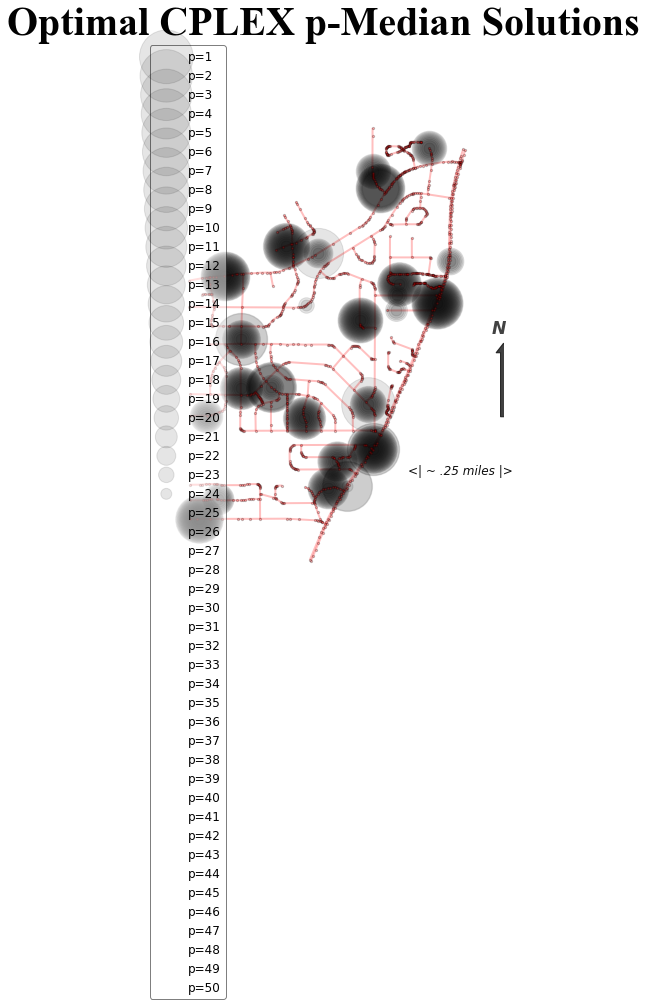

In [38]:
# p-Median Cplex
P_Med_Graphs_cplex = OrderedDict()
for x in range(1, len(SER)+1):
    P_Med_Graphs_cplex["{0}".format(x)] = nx.Graph()

#PMP
size = 3000
for i,j in P_Med_Graphs_cplex.iteritems():
    size=size-120
    # p-Median
    P_Med_cplex = ps.open(path+'Results/CPLEX_Selected_Locations_Pmedian'+str(i)+'.shp')
    points_median_cplex = {}
    for idx, coords in enumerate(P_Med_cplex):
        P_Med_Graphs_cplex[i].add_node(idx)
        points_median_cplex[idx] = coords
        P_Med_Graphs_cplex[i].node[idx] = coords
    nx.draw(P_Med_Graphs_cplex[i], 
                points_median_cplex, 
                node_size=size, 
                alpha=.1, 
                node_color='k')

# Draw Network Actual Roads and Nodes
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
for i in P_Med_Graphs_cplex:
    LEGEND['p='+str(i)]=P_Med_Graphs_cplex[i]
plt.legend(LEGEND, 
       loc='upper left', 
       fancybox=True, 
       framealpha=0.5, 
       scatterpoints=1)

# Title
plt.title('Optimal CPLEX p-Median Solutions', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
plt.arrow(624000, 164050, 0.0, 500, width=50, head_width=125, 
          head_length=75, fc='k', ec='k',alpha=0.75,)
plt.annotate('N', xy=(623900, 164700), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)
plt.annotate('<| ~ .25 miles |>', xy=(623200, 163600), 
             fontstyle='italic', fontsize='large', alpha=0.95)

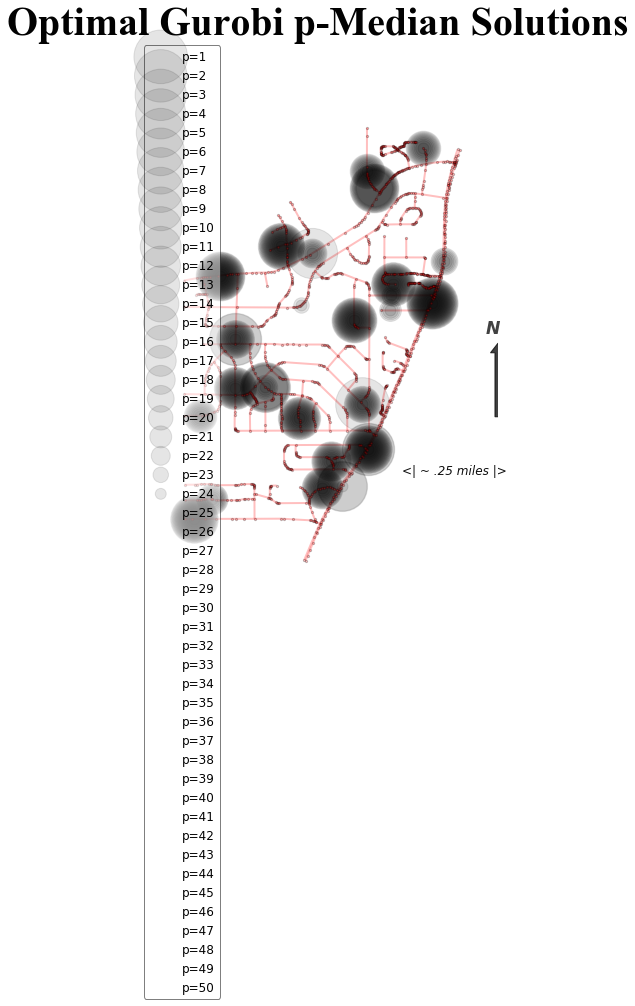

In [39]:
# p-Median Gurobi
P_Med_Graphs_gurobi = OrderedDict()
for x in range(1, len(SER)+1):
    P_Med_Graphs_gurobi["{0}".format(x)] = nx.Graph()

#PMP
size = 3000
for i,j in P_Med_Graphs_gurobi.iteritems():
    size=size-120
    # p-Median
    P_Med_gurobi = ps.open(path+'Results/GUROBI_Selected_Locations_Pmedian'+str(i)+'.shp')
    points_median_gurobi = {}
    for idx, coords in enumerate(P_Med_gurobi):
        P_Med_Graphs_gurobi[i].add_node(idx)
        points_median_gurobi[idx] = coords
        P_Med_Graphs_gurobi[i].node[idx] = coords
    nx.draw(P_Med_Graphs_gurobi[i], 
                points_median_gurobi, 
                node_size=size, 
                alpha=.1, 
                node_color='k')

# Draw Network Actual Roads and Nodes
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
for i in P_Med_Graphs_gurobi:
    LEGEND['p='+str(i)]=P_Med_Graphs_gurobi[i]
plt.legend(LEGEND, 
       loc='upper left', 
       fancybox=True, 
       framealpha=0.5, 
       scatterpoints=1)

# Title
plt.title('Optimal Gurobi p-Median Solutions', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
plt.arrow(624000, 164050, 0.0, 500, width=50, head_width=125, 
          head_length=75, fc='k', ec='k',alpha=0.75,)
plt.annotate('N', xy=(623900, 164700), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)
plt.annotate('<| ~ .25 miles |>', xy=(623200, 163600), 
             fontstyle='italic', fontsize='large', alpha=0.95)

In [40]:
source_cplex = ColumnDataSource(
        data=dict(
            x=range(1, len(SER)+1),
            y=AVG_PMP_cplex,
            avg=AVG_PMP_cplex,
            desc=p_list,
            change=PMP_Avg_Diff_cplex))

TOOLS = 'wheel_zoom, pan, reset, crosshair, save'

hover = HoverTool(line_policy="nearest", mode="hline", tooltips="""
        <div>
            <div>
                
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span> 
            </div>
            <div>
                <span style="font-size: 15px;">Average Minimized Cost CPLEX</span>
                <span style="font-size: 15px; font-weight: bold; color: #ff4d4d;">[@avg]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Variation</span>
                <span style="font-size: 15px; font-weight: bold; color: #ff4d4d;">[@change]</span>
            </div>
        </div>""")

# Instantiate Plot
pmp_plot_cplex = figure(plot_width=600, plot_height=600, tools=[TOOLS,hover],
           title="Average Distance vs. p-Facilities CPLEX", y_range=(0,2))

# Create plot points and set source
pmp_plot_cplex.circle('x', 'y', size=15, color='red',source=source_cplex, 
                legend='Total Minimized Cost / Total Demand')
pmp_plot_cplex.line('x', 'y', line_width=2, color='red', alpha=.5, source=source_cplex, 
              legend='Total Minimized Cost / Total Demand')

pmp_plot_cplex.xaxis.axis_label = '[p = n]'
pmp_plot_cplex.yaxis.axis_label = 'Miles'

one_quarter = BoxAnnotation(plot=pmp_plot_cplex, top=.35, 
                            fill_alpha=0.1, fill_color='green')
half = BoxAnnotation(plot=pmp_plot_cplex, bottom=.35, top=.7, 
                            fill_alpha=0.1, fill_color='blue')
three_quarter = BoxAnnotation(plot=pmp_plot_cplex, bottom=.7, top=1.05,
                            fill_alpha=0.1, fill_color='gray')

pmp_plot_cplex.renderers.extend([one_quarter, half, three_quarter])

# Display the figure
show(pmp_plot_cplex)

In [41]:
source_gurobi = ColumnDataSource(
        data=dict(
            x=range(1, len(SER)+1),
            y=AVG_PMP_gurobi,
            avg=AVG_PMP_gurobi,
            desc=p_list,
            change=PMP_Avg_Diff_gurobi))

TOOLS = 'wheel_zoom, pan, reset, crosshair, save'

hover = HoverTool(line_policy="nearest", mode="hline", tooltips="""
        <div>
            <div>
                
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span> 
            </div>
            <div>
                <span style="font-size: 15px;">Average Minimized Cost CPLEX</span>
                <span style="font-size: 15px; font-weight: bold; color: #ff4d4d;">[@avg]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Variation</span>
                <span style="font-size: 15px; font-weight: bold; color: #ff4d4d;">[@change]</span>
            </div>
        </div>""")

# Instantiate Plot
pmp_plot_gurobi = figure(plot_width=600, plot_height=600, tools=[TOOLS,hover],
           title="Average Distance vs. p-Facilities Gurobi", y_range=(0,2))

# Create plot points and set source
pmp_plot_gurobi.circle('x', 'y', size=15, color='red',source=source_gurobi, 
                legend='Total Minimized Cost / Total Demand')
pmp_plot_gurobi.line('x', 'y', line_width=2, color='red', alpha=.5, source=source_gurobi, 
              legend='Total Minimized Cost / Total Demand')

pmp_plot_gurobi.xaxis.axis_label = '[p = n]'
pmp_plot_gurobi.yaxis.axis_label = 'Miles'

one_quarter = BoxAnnotation(plot=pmp_plot_gurobi, top=.35, 
                            fill_alpha=0.1, fill_color='green')
half = BoxAnnotation(plot=pmp_plot_gurobi, bottom=.35, top=.7, 
                            fill_alpha=0.1, fill_color='blue')
three_quarter = BoxAnnotation(plot=pmp_plot_gurobi, bottom=.7, top=1.05,
                            fill_alpha=0.1, fill_color='gray')

pmp_plot_gurobi.renderers.extend([one_quarter, half, three_quarter])

# Display the figure
show(pmp_plot_gurobi)

In [42]:
TOOLS = 'wheel_zoom, pan, reset, crosshair, save, hover'

source_cplex = ColumnDataSource(
        data=dict(
            x=range(1, len(SER)+1),
            y=solve_time_cplex,
            obj=solve_time_cplex,
            desc=p_list))

source_gurobi = ColumnDataSource(
        data=dict(
            x=range(1, len(SER)+1),
            y=solve_time_gurobi,
            obj=solve_time_gurobi,
            desc=p_list))


plot_solve_time = figure(title="Solution Time Comparison", 
                        plot_width=600, plot_height=400, tools=[TOOLS], y_range=(0,4))

plot_solve_time.circle('x', 'y', size=5, color='red', source=source_cplex, legend='CPLEX')
plot_solve_time.line('x', 'y', 
                 color="#ff4d4d", alpha=0.2, line_width=2, source=source_cplex, legend='CPLEX')

plot_solve_time.circle('x', 'y', size=5, color='green', source=source_gurobi, legend='Gurobi')
plot_solve_time.line('x', 'y', 
                 color='#00b300', alpha=0.2, line_width=2, source=source_gurobi, legend='Gurobi')


plot_solve_time.xaxis.axis_label = '[p = n]'
plot_solve_time.yaxis.axis_label = 'Seconds'

one_quarter = BoxAnnotation(plot=plot_solve_time, top=.35, 
                            fill_alpha=0.1, fill_color='green')
half = BoxAnnotation(plot=plot_solve_time, bottom=.35, top=.7, 
                            fill_alpha=0.1, fill_color='blue')
three_quarter = BoxAnnotation(plot=plot_solve_time, bottom=.7, top=1.05,
                            fill_alpha=0.1, fill_color='gray')

plot_solve_time.renderers.extend([one_quarter, half, three_quarter])

show(plot_solve_time)

In [43]:
points = SERVICE
points.to_crs(epsg=32616, inplace=True) # UTM 16N
LonLat_Dict = OrderedDict()
LonLat_List = []

for i,j in points['geometry'].iteritems():
    LonLat_Dict[y_list[i]] = utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')  
    LonLat_List.append((utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')))

Service_Lat_List = []
Service_Lon_List = []
    
for i in LonLat_List:
    Service_Lat_List.append(i[0])
for i in LonLat_List:
    Service_Lon_List.append(i[1])

In [44]:
# p-Median Selected Sites CPLEX
list_of_p_MEDIAN_cplex = []
for y in range(len(y_list)):
    list_of_p_MEDIAN_cplex.append([])
    for p in range(len(p_list)):
        if pydf_M_cplex[y_list[y]][p_list[p]] == u'\u2588':
            list_of_p_MEDIAN_cplex[y].append([p_list[p]])
            
# p-Median Selected Sites Gurobi
list_of_p_MEDIAN_gurobi = []
for y in range(len(y_list)):
    list_of_p_MEDIAN_gurobi.append([])
    for p in range(len(p_list)):
        if pydf_M_gurobi[y_list[y]][p_list[p]] == u'\u2588':
            list_of_p_MEDIAN_gurobi[y].append([p_list[p]])

In [45]:
map_options = GMapOptions(lat=30.4855, lng=-84.265, map_type="hybrid", zoom=14)

plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)

hover = HoverTool(tooltips="""
        <div>
            <div>
                
            </div>
            <div>
                <span style="font-size: 30px; font-weight: bold;">Site @desc</span> 
            </div>
            <div>
                <span> \b </span>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">CPLEX</span> 
            </div>
                <div>
                <span style="font-size: 15px; font-weight: bold; color: #ff4d4d;">@p_select_median_cplex</span>
            </div>
            <div>
                <span> \b </span>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">Gurobi</span> 
            
            <div>
                <span style="font-size: 15px; font-weight: bold; color: #00b300;">@p_select_median_gurobi</span>
            </div>
        </div>""")

source_1 = ColumnDataSource(
        data=dict(
        lat=Service_Lat_List,
        lon=Service_Lon_List,
        desc=y_list,
        p_select_median_cplex=list_of_p_MEDIAN_cplex,
        p_select_median_gurobi=list_of_p_MEDIAN_gurobi))

facilties = Circle(x="lon", y="lat", 
                   size=10, fill_color="yellow", 
                   fill_alpha=0.6, line_color=None)

plot.add_glyph(source_1, facilties)

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), ResetTool(), hover)
output_file("gmap_plot.html")
show(plot)

-----